In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta

In [2]:
#define the ticker symbol
tickerSymbol = 'AAPL'

In [3]:
#get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

In [4]:
#get the historical prices for this ticker
tickerDf = tickerData.history(interval='1d', start='2018-01-01', end='2023-01-01')

In [5]:
tickerDf

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-01-02 00:00:00-05:00,40.226432,40.732336,40.013667,40.722878,102223600,0.0,0.0
2018-01-03 00:00:00-05:00,40.786708,41.264244,40.651960,40.715786,118071600,0.0,0.0
2018-01-04 00:00:00-05:00,40.789072,41.008929,40.680328,40.904911,89738400,0.0,0.0
2018-01-05 00:00:00-05:00,41.001824,41.458081,40.909627,41.370613,94640000,0.0,0.0
2018-01-08 00:00:00-05:00,41.216965,41.514832,41.117672,41.216965,82271200,0.0,0.0
...,...,...,...,...,...,...,...
2022-12-23 00:00:00-05:00,130.192267,131.683929,128.919384,131.127045,63814900,0.0,0.0
2022-12-27 00:00:00-05:00,130.649753,130.679585,128.004535,129.307251,69007800,0.0,0.0
2022-12-28 00:00:00-05:00,128.949237,130.301678,125.170363,125.339417,85438400,0.0,0.0


In [7]:
priceData = tickerDf.Open

Text(0.5, 1.0, 'AAPL Price Data')

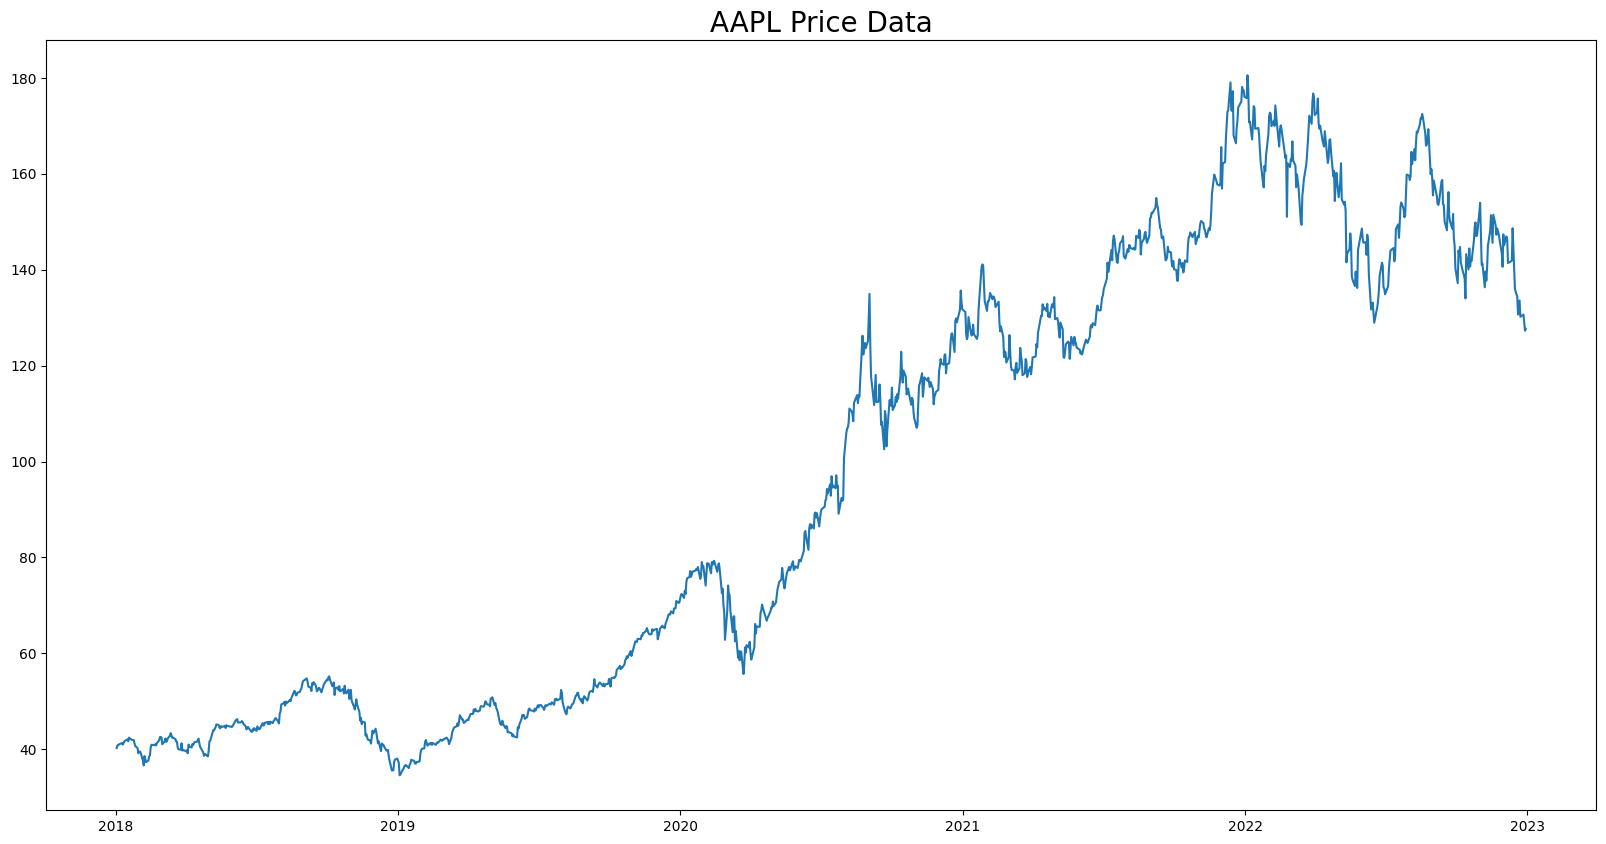

In [8]:
plt.figure(figsize=(20,10))
plt.plot(priceData)
plt.title("%s Price Data"%tickerSymbol, fontsize=20)

In [9]:
priceData = priceData.asfreq(pd.infer_freq(priceData.index))

Text(0.5, 1.0, 'AAPL Price Data')

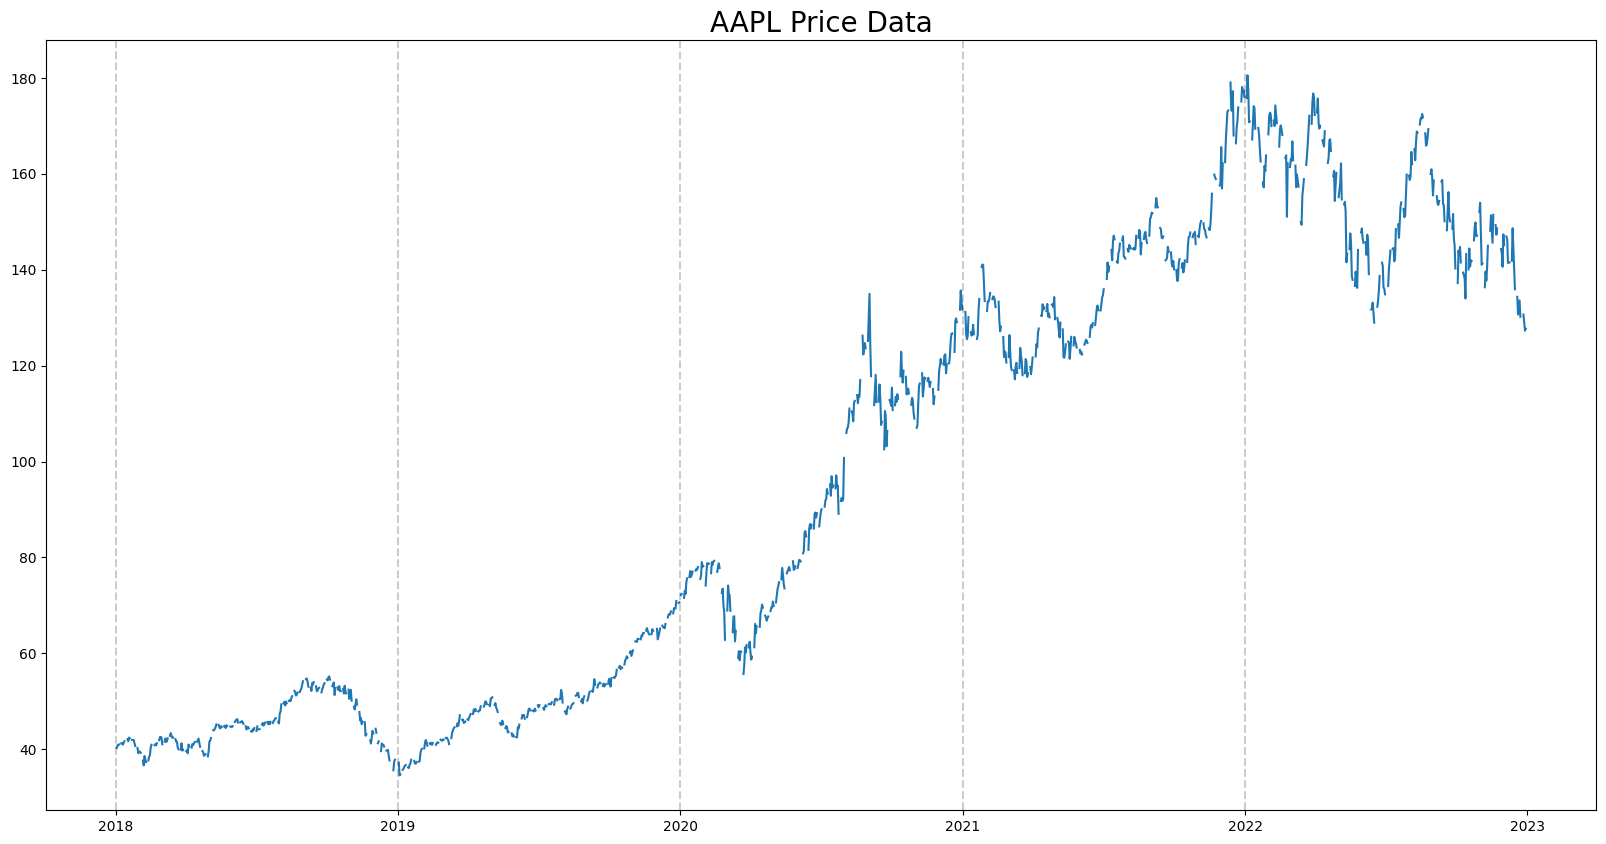

In [10]:
plt.figure(figsize=(20,10))
plt.plot(priceData)
for year in range(priceData.index[1].year, priceData.index[-1].year+1):
    plt.axvline(datetime(year,1,1), color='k', linestyle='--', alpha=0.2)
plt.title("%s Price Data"%tickerSymbol, fontsize=20)

## Basic Buying Protocol:
- Buy if stock increasing for __b__ consecutive days

## Basic Selling Protocols:
- Sell if stock decreasing for __s__ consecutive days __and__ we have made a profit

In [11]:
def get_buying_selling_days(price_data, b, s):
    
    #get the percent change day after day
    pct_change = price_data.pct_change()[1:]
    
    #this function checks the buying condition
    def buying_condition(sub_series):
        return (sub_series > 0).all()
    
    #this function checks the selling condition
    def selling_condition(sub_series):
        return (sub_series < 0).all()
    
    #get all buying days in the data
    buying_days = pct_change.rolling(b).apply(buying_condition)
    
    #get all potential selling days in the data
    potential_selling_days = pct_change.rolling(s).apply(selling_condition)
    
    #return a dictionary
    return {'buying_days': buying_days, 'potential_selling_days': potential_selling_days}

In [12]:
info_dict = get_buying_selling_days(priceData, 3, 3)

C:\Users\user\AppData\Local\Temp\ipykernel_18044\3708491760.py:4: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pct_change = price_data.pct_change()[1:]


In [13]:
buying_days = info_dict['buying_days']
potential_selling_days = info_dict['potential_selling_days']

In [14]:
#create dataframe to store information
df_stocks = pd.DataFrame(index = buying_days.index)

In [15]:
#populate df with buying days, possible selling days, and price
df_stocks['buying_day'] = (buying_days == 1)
df_stocks['potential_selling_day'] = (potential_selling_days == 1)
df_stocks['price'] = priceData

#only keep days that are buying or possible selling days
df_stocks = df_stocks[(df_stocks.buying_day | df_stocks.potential_selling_day)]

In [16]:
def check_cumulative_percent_change(price_data, buy_date, potential_sell_date):
    """
    This helper function will check if the cumulative percent change
    between a buying and potential selling day yields overall growth
    """
    
    #get the percent change day after day
    pct_change = price_data.pct_change()[1:]
    
    sub_series = 1 + pct_change[buy_date + timedelta(hours=1): potential_sell_date]

    return sub_series.product() > 1

In [17]:
def get_investing_result(df_stocks, starting_funds, verbose=False):
    
    #get a copy of price data
    price_data = df_stocks.price
    
    #at start, not holding any shares
    holding = False
    
    #init vars
    current_funds = starting_funds
    current_shares = 0
    last_buy_date = None
    
    #init dict of buying and selling dates
    events_list = []
    
    #for each buying day and potential selling day...
    for date,data in df_stocks.iterrows():
        
        #if not currently holding shares, and this is a buying day...
        if (not holding) and data.buying_day:
            
            #calculate the number of shares we can buy
            num_shares_to_buy = int(current_funds / data.price)
            
            #update number of shares
            current_shares += num_shares_to_buy
            
            #decrease current funds
            current_funds -= num_shares_to_buy * data.price
            
            #set last buy date
            last_buy_date = date
            events_list.append(('b', date))
            
            #we are now holding shares
            holding = True
            
            if verbose:
                print('Bought %s shares at $%s on %s totaling $%s'%(num_shares_to_buy, data.price, date.date(), round(num_shares_to_buy*data.price,2)))
        
        #if you are holding shares, and this is a potential selling day...
        elif holding and data.potential_selling_day:
            
            #check to make sure we're making a profit
            #if check_cumulative_percent_change(price_data, last_buy_date, date):
                #add to our current funds
                current_funds += current_shares * data.price
                
                if verbose:
                    print('Sold %s shares at $%s on %s totaling $%s'%(current_shares, data.price, date.date(), round(num_shares_to_buy*data.price,2)))
                    print('--------------------------------------')
                    
                #reset current shares
                current_shares = 0
                
                #we are no longer holding shares
                holding = False
                
                events_list.append(('s', date))
                
    #get the stock price at the end of the time span
    final_stock_price = price_data[-1]
        
    #get the final total value of all assets (funds + stock value)
    final_value = current_funds + final_stock_price * current_shares
    
    #return the percent change in value
    return round((final_value - starting_funds) / starting_funds,2), events_list

In [18]:
percent_change, events_list = get_investing_result(df_stocks, 10000, False)

C:\Users\user\AppData\Local\Temp\ipykernel_18044\1032285092.py:63: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  final_stock_price = price_data[-1]


In [19]:
print(round(percent_change*100),'%')

12 %


(32.0, 189.0)

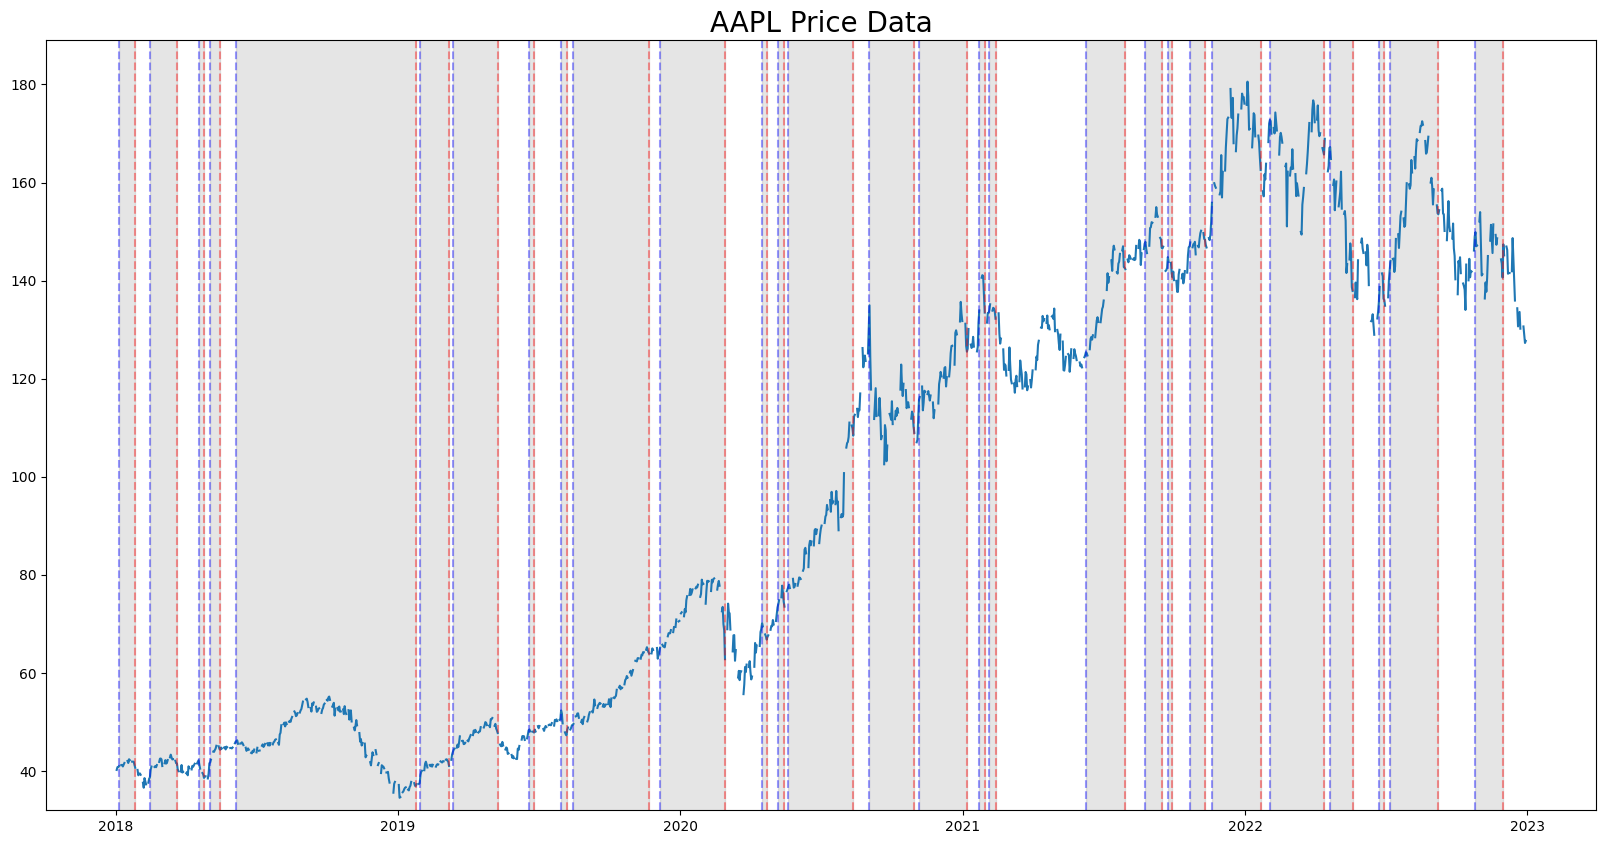

In [20]:
plt.figure(figsize=(20,10))
plt.plot(priceData)

y_lims = (int(priceData.min()*.95), int(priceData.max()*1.05))
shaded_y_lims = int(priceData.min()*.5), int(priceData.max()*1.5)

for idx, event in enumerate(events_list):
    color = 'red' if event[0] == 's' else 'blue'
    plt.axvline(event[1], color=color, linestyle='--', alpha=0.4)
    if event[0] == 's':
        plt.fill_betweenx(range(*shaded_y_lims), 
                          event[1], events_list[idx-1][1], color='k', alpha=0.1)

plt.title("%s Price Data"%tickerSymbol, fontsize=20)
plt.ylim(*y_lims)